## Water Extraction Forecasting

The data includes the date-time from 2013 to 2018 in a daily frequency. 

The complete feature list is as follows:

* Date: Day - Month - Year format
* DHIAv: Direct Horizontal Irradiance - Average
* DHIMax: Direct Horizontal Irradiance - Max 
* DNIAv: Direct Normal Irradiance - Average
* DNIMax: Direct Normal Irradiance - Max
* GHIAv: Global Horizontal Irradiance - Average
* GHIMax: Global Horizontal Irradiance - Max
* CDHIAv: Clearsky DHI - Average
* CDHIMax: Clearsky DHI - Max
* CDNIAv: Clearksy DNI - Average
* CDNIMax: Clearksy DNI - Max
* CGHIAv: Clearsky GHI - Average
* CGHIMax: Clearsky GHI - Max
* DPMin: Dew Point - Min
* DPAv: Dew Point - Average
* DPMax: Dew Point - Max
* WSMin: Wind Speed - Min
* WSAv: Wind Speed - Average
* WSMax: Wind Speed - Max
* RainMin: Rain - Min
* RainAv: Rain - Average
* RainMax: Rain - Max
* RHMin: Relative Humidity - Min
* RHAv: Relative Humidity - Average
* RHMax: Relative Humidity - Max
* Tmin: Temperature - Min
* TAv: Temperature - Average
* TMax: Temperature - Max
* PMin: Pressure - Min
* PAv: Pressure - Average
* PMax: Pressure - Max
* year: Year, goes from 2013 to 2018
* month: Month, goes from 1 to 12
* day: Day, goes from 1 to 31
* Weekday: Weekday (1: yes) 
* Weekend: Weekend (1: yes)
* Festive: Festive (free labor day) (1: yes)

Desired forecast feature:
* Q: Volumetric flowrate used during that day from the natural sources to provide the city with the demanded water 

Total data points: 2191
Total features: 37

### Some features might be subject for elimination, such as: 

#### Irradiance:
* DHIAv: Direct Horizontal Irradiance - Average
* DHIMax: Direct Horizontal Irradiance - Max 
* DNIAv: Direct Normal Irradiance - Average
* DNIMax: Direct Normal Irradiance - Max
* GHIAv: Global Horizontal Irradiance - Average
* GHIMax: Global Horizontal Irradiance - Max
* CDHIAv: Clearsky DHI - Average
* CDHIMax: Clearsky DHI - Max
* CDNIAv: Clearksy DNI - Average
* CDNIMax: Clearksy DNI - Max
* CGHIAv: Clearsky GHI - Average
* CGHIMax: Clearsky GHI - Max

#### Due to lack of APIs that contain said variables

#### Time:
* year: Year, goes from 2013 to 2018
* month: Month, goes from 1 to 12
* day: Day, goes from 1 to 31
#### Information might be duplicated as the date is already added

#### Any other feature after a PCA is done

Based on:
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## Import libraries

In [85]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from datetime import datetime

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow as tf

## Pre-processing

In [86]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d')

dataset = read_csv("C:/Users/3PX00LA_RS4/Documents/ATOS challenge/DemandaDiaria/Datasets-old/DataFinalLSTM.csv",  parse_dates = [['year', 'month', 'day']], index_col=0, date_parser=parse)

# drop the old index column named "No"
dataset.drop('No', axis=1, inplace=True)

# set date as index
dataset.index.name = 'date'

# check for nulls
display('-'*100)
display(dataset.isnull().any())

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv("C:/Users/3PX00LA_RS4/Documents/ATOS challenge/DemandaDiaria/Datasets-old/" + "DataFinalLSTMCleaned.csv")

'----------------------------------------------------------------------------------------------------'

Q          False
DHIAv      False
DHIMax     False
DNIAv      False
DNIMax     False
GHIAv      False
GHIMax     False
CDHIAv     False
CDHIMax    False
CDNIAv     False
CDNIMax    False
CGHIAv     False
CGHIMax    False
DPMin      False
DPAv       False
DPMax      False
WSMin      False
WSAv       False
WSMax      False
RainMin    False
RainAv     False
RainMax    False
RHMin      False
RHAv       False
RHMax      False
TMin       False
TAv        False
TMax       False
PMin       False
PAv        False
PMax       False
Weekday    False
Weekend    False
Festive    False
dtype: bool

                     Q      DHIAv  DHIMax       DNIAv  DNIMax       GHIAv  \
date                                                                        
2013-01-01  10782.8398  60.041667     232    9.083333     145   64.625000   
2013-01-02   8289.3878  42.875000     165    0.041667       1   42.916667   
2013-01-03   9153.6818  46.000000     192  125.375000     792  106.833333   
2013-01-04   8894.7788  44.375000     166  145.791667     823  110.583333   
2013-01-05   9691.8726  64.875000     291  180.791667     896  153.500000   

            GHIMax     CDHIAv  CDHIMax      CDNIAv  ...  RHMax  TMin  \
date                                                ...                
2013-01-01     271  37.041667      118  291.458333  ...  100.0  10.0   
2013-01-02     166  41.125000      129  274.583333  ...  100.0   8.0   
2013-01-03     666  49.125000      156  263.291667  ...  100.0   5.0   
2013-01-04     669  44.625000      135  271.791667  ...  100.0   5.0   
2013-01-05     684  36.37500

## LSTM Data Preparation

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

### Important: We will frame the supervised learning problem as predicting the Q (volumetric flowrate) at the current day (t) given the day-time conditions and weather conditions at the PRIOR time step.

### Convert series to supervised learning

In [87]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [88]:
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]], axis=1, inplace=True)

print(reframed)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.401111   0.288779   0.361419   0.020703   0.138095   0.135440   
2      0.072853   0.169324   0.212860   0.000095   0.000952   0.071638   
3      0.186635   0.191070   0.272727   0.285755   0.754286   0.259491   
4      0.152551   0.179762   0.215078   0.332289   0.783810   0.270512   
5      0.257487   0.322412   0.492239   0.412061   0.853333   0.396645   
...         ...        ...        ...        ...        ...        ...   
2186   0.435361   0.155697   0.290466   0.563533   0.887619   0.427749   
2187   0.544497   0.053059   0.013304   0.815575   0.953333   0.518981   
2188   0.586098   0.165265   0.283814   0.658310   0.960000   0.468773   
2189   0.628620   0.141490   0.281596   0.023457   0.075238   0.069557   
2190   0.479068   0.151638   0.294900   0.012346   0.050476   0.072496   

      var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var26(t-1)  \
1      0.182644   0.127690   0.157270    

## Define and Fit Model

In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first 3 years of data, then evaluate it on the remaining 3 years of data. 

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

### Split into train and test sets

Running this example prints the shape of the train and test input and output sets with about 1095 days of data for training and about 1095 days for testing.

In [89]:
# split into train and test sets
values = reframed.values
n_train_days = 365*5
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1825, 1, 34) (1825,) (365, 1, 34) (365,)


We will define the LSTM with **50 neurons** in the **first hidden layer** and **1 neuron** in the **output** layer for predicting Q. The input shape will be 1 time step with 34 features.

We will use the **Mean Absolute Error (MAE)** loss function and the efficient **Adam version of stochastic gradient descent**.

The model will be fit for **50 training epochs** with a **batch size of True**. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [90]:
# design network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

Train on 1825 samples, validate on 365 samples
Epoch 1/50
1825/1825 - 7s - loss: 0.0716 - val_loss: 0.0671
Epoch 2/50
1825/1825 - 4s - loss: 0.0679 - val_loss: 0.0642
Epoch 3/50
1825/1825 - 5s - loss: 0.0676 - val_loss: 0.0664
Epoch 4/50
1825/1825 - 5s - loss: 0.0670 - val_loss: 0.0739
Epoch 5/50
1825/1825 - 4s - loss: 0.0669 - val_loss: 0.0830
Epoch 6/50
1825/1825 - 4s - loss: 0.0662 - val_loss: 0.0885
Epoch 7/50
1825/1825 - 4s - loss: 0.0659 - val_loss: 0.0900
Epoch 8/50
1825/1825 - 4s - loss: 0.0661 - val_loss: 0.0944
Epoch 9/50
1825/1825 - 4s - loss: 0.0656 - val_loss: 0.1031
Epoch 10/50
1825/1825 - 4s - loss: 0.0656 - val_loss: 0.1122
Epoch 11/50
1825/1825 - 4s - loss: 0.0654 - val_loss: 0.1163
Epoch 12/50
1825/1825 - 4s - loss: 0.0648 - val_loss: 0.1036
Epoch 13/50
1825/1825 - 4s - loss: 0.0642 - val_loss: 0.1116
Epoch 14/50
1825/1825 - 4s - loss: 0.0643 - val_loss: 0.1130
Epoch 15/50
1825/1825 - 5s - loss: 0.0645 - val_loss: 0.1172
Epoch 16/50
1825/1825 - 4s - loss: 0.0640 - val

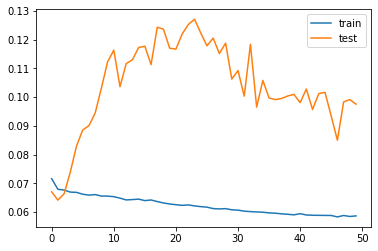

In [91]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=True, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Running the example first creates a plot showing the train and test loss during training.

Interestingly, we can see that test loss drops below training loss. The model may be **overfitting the training data**. Measuring and plotting RMSE during training may shed more light on this.

The Train and test loss are printed at the end of each training epoch. At the end of the run, the final RMSE of the model on the test dataset is printed.

We can see that the model achieves a respectable RMSE of 23.496, which is lower than an RMSE of 30 found with a persistence model.

## Evaluate the model

After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [92]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [93]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [94]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [95]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 874.316


#### y_inv and y_pred_inv are 365 (1 year), because the train was 5 years (see n_train_days)

In [104]:
print (inv_y.shape, inv_yhat.shape)

(365,) (365,)


### Lets merge y real and predicted into DataFrame for simplicity

In [106]:
y_comparison = pd.DataFrame({"Q real": inv_y,
                            "Q forecast": inv_yhat})

y_comparison.head()

,Q real,Q forecast
0,12191.0,10856.849609
1,9598.0,10402.141602
2,9968.0,10727.134766
3,12108.0,11406.385742
4,12556.0,12258.476562


### Plot of forecast vs real

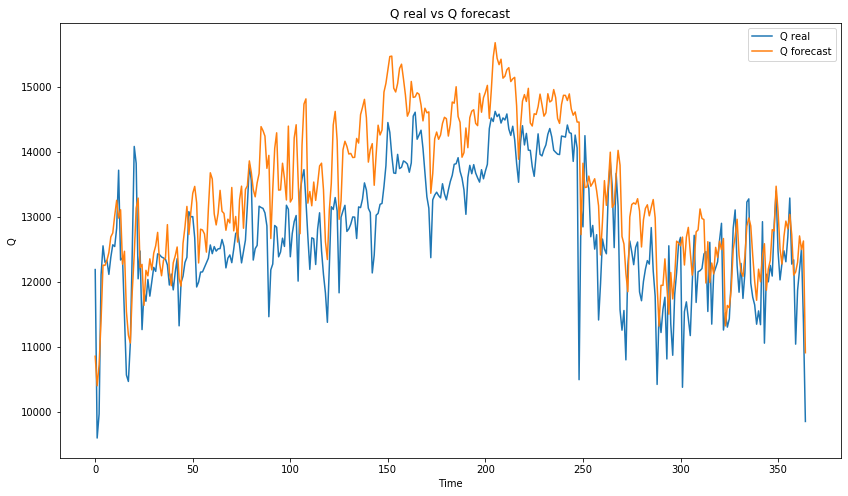

In [103]:
plt.figure(figsize=(14, 8))
plt.title("Q real vs Q forecast")
plt.plot(y_comparison["Q real"], label = "Q real")
plt.plot(y_comparison["Q forecast"], label = "Q forecast")
plt.xlabel("Time")
plt.ylabel("Q")
plt.legend()